#### Training with NSL-KDD for all classes

Get dataset from `https://github.com/jmnwong/NSL-KDD-Dataset`.

In [5]:
print("Reading Training csv file.")
df1 = pd.read_csv("KDDTrain+.txt")
print("Reading Testing csv file.")
df2 = pd.read_csv("KDDTest+.txt")
df1.drop(df1.columns[-1], axis=1, inplace=True)  
df2.drop(df2.columns[-1], axis=1, inplace=True)  
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

df1.columns = col_names
df2.columns = col_names

df = pd.concat([df1, df2])

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['protocol_type'])
df['protocol_type'] = le.transform(df['protocol_type'])

le = preprocessing.LabelEncoder()
le.fit(df['service'])
df['service'] = le.transform(df['service'])

le = preprocessing.LabelEncoder()
le.fit(df['flag'])
df['flag'] = le.transform(df['flag'])

X= df.values[:,:-1]
Y = df.values[:,-1]
print (X.shape,Y.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
print (X_train.shape,X_test.shape, y_train.shape, y_test.shape)

Reading Training csv file.
Reading Testing csv file.
(148515, 41) (148515,)
(99505, 41) (49010, 41) (99505,) (49010,)


In [8]:
labels_list = df["labels"].unique().tolist()
print(labels_list)

['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep', 'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back', 'guess_passwd', 'ftp_write', 'multihop', 'rootkit', 'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land', 'loadmodule', 'spy', 'perl', 'saint', 'mscan', 'apache2', 'snmpgetattack', 'processtable', 'httptunnel', 'ps', 'snmpguess', 'mailbomb', 'named', 'sendmail', 'xterm', 'worm', 'xlock', 'xsnoop', 'sqlattack', 'udpstorm']


In [10]:
from sklearn import tree
from sklearn.model_selection import cross_val_predict

#dt_clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)
#dt_clf = tree.DecisionTreeClassifier(max_depth=4, max_leaf_nodes=20)
dt_clf = tree.DecisionTreeClassifier(max_depth=8)

#y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=2)
print(dt_clf.fit(X_train, y_train))

print('Number of nodes in the decision tree {}.'.format(dt_clf.tree_.node_count))
print('Number of threshold in the decision tree {}.'.format(len(dt_clf.tree_.threshold)))
print('Number of leaves in the decision tree {}.'.format(dt_clf.tree_.n_leaves))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, dt_clf.predict(X_test)), accuracy_score(y_train, dt_clf.predict(X_train)))

DecisionTreeClassifier(max_depth=8)
Number of nodes in the decision tree 251.
Number of threshold in the decision tree 251.
Number of leaves in the decision tree 126.
0.962375025504999 0.9658409125169589


In [11]:
threshold = dt_clf.tree_.threshold
import pandas as pd
df_train = pd.DataFrame(data = X_train, columns = range(X_train[0].shape[0]))
df_test = pd.DataFrame(data = X_test, columns = range(X_test[0].shape[0]))
df_train.shape, df_test.shape
df = pd.concat([df_train, df_test])
unique_vals = []
for i in df.columns:
    unique_vals.append(df[i].unique())
flatten_list = np.concatenate(unique_vals).ravel()
print('Max and Min values of thresholds in decision tree are', max([int(i) for i in list(set(threshold))]), min([int(i) for i in list(set(threshold))]))

Max and Min values of thresholds in decision tree are 54614 -2


#### Displaying the nodes/leaves that were visited for training each class. Also display which are the intermeduate nodes and which are the leaves.

In [12]:
# Get the paths to the leaf nodes for each class
clf = dt_clf
leaf_paths = {}
for class_label in np.unique(y_train):
    leaf_paths[class_label] = clf.decision_path(X_train[y_train == class_label])

# Group the leaf nodes for each class
class_groups = {}
for class_label, paths in leaf_paths.items():
    group = {'leaves': set(), 'intermediate': set()}
    for path in paths:
        # Get the indices of the nodes in the path
        node_indices = np.where(path.toarray().flatten())[0]
        # Identify leaf nodes and intermediate nodes
        for idx in node_indices:
            node = clf.tree_.value[idx].argmax()
            if clf.tree_.children_left[idx] == -1 and clf.tree_.children_right[idx] == -1:
                # Verify leaf node belongs to the current class
                if node == class_label:
                    group['leaves'].add(idx)
            else:
                group['intermediate'].add(idx)
    class_groups[class_label] = group

# Verify leaf nodes don't belong to other classes
for class_label, groups in class_groups.items():
    for other_class_label, other_groups in class_groups.items():
        if other_class_label != class_label:
            intersection = groups['leaves'].intersection(other_groups['leaves'])
            if intersection:
                print(f"Warning: Leaf nodes for class {class_label} intersect with class {other_class_label}: {intersection}")

leaf_nodes_per_class = {}
intermediate_nodes_per_class = {}
# Print the groups
for class_label, groups in class_groups.items():
    print(f"Class {class_label}:")
    print("Intermediate Nodes:", groups['intermediate'])
    intermediate_nodes_per_class[class_label] = groups['intermediate']
    print("Leaf Nodes:", groups['leaves'])
    leaf_nodes_per_class[class_label] = groups['leaves']

Class apache2:
Intermediate Nodes: {0, 148, 149, 150, 151, 152, 153, 160, 168, 200, 201, 202, 203, 204, 230, 231, 104, 237, 240, 241, 245, 248}
Leaf Nodes: set()
Class back:
Intermediate Nodes: {0, 230, 231, 104, 200, 232, 233, 201, 202, 203, 207, 148}
Leaf Nodes: set()
Class buffer_overflow:
Intermediate Nodes: {0, 1, 2, 148, 149, 150, 151, 152, 156, 30, 42, 52, 56, 57, 200, 201, 202, 203, 207, 217, 223, 227, 104}
Leaf Nodes: set()
Class ftp_write:
Intermediate Nodes: {0, 104, 200, 201, 202, 203, 204, 148, 149, 150, 151, 152, 153, 156}
Leaf Nodes: set()
Class guess_passwd:
Intermediate Nodes: {0, 1, 2, 148, 149, 150, 151, 30, 42, 171, 172, 43, 44, 45, 180, 181, 185, 186, 187, 190, 200, 201, 202, 203, 207, 210, 211, 217, 218, 223, 224, 104}
Leaf Nodes: set()
Class httptunnel:
Intermediate Nodes: {0, 1, 2, 3, 148, 149, 21, 22, 23, 24, 171, 172, 173, 174, 185, 186, 187, 200, 201, 202, 203, 204, 207, 230, 231, 104, 237}
Leaf Nodes: set()
Class imap:
Intermediate Nodes: {0, 104, 201, 200, 

##### Sanity checks that there is no sharing of leaves between classes.

In [13]:
for i in intermediate_nodes_per_class.keys():
    for j in leaf_nodes_per_class.keys():
        if i!=j:
            intersection = leaf_nodes_per_class[i].intersection(leaf_nodes_per_class[j])
            if intersection:
                print(f'Warning: The leaf nodes between class {i} and {j} has common leaves: {intersection}.')
    

#### Creating a set containing intermediate nodes and leafs.

In [14]:
intermediate_nodes = set()
leaf_nodes = set()
for i in intermediate_nodes_per_class.keys():
    intermediate_nodes.update(intermediate_nodes_per_class[i])
    
for j in leaf_nodes_per_class.keys():
    leaf_nodes.update(leaf_nodes_per_class[j])

##### Check the nodes that were used in forget class but not in other classes.

In [19]:
forget_class = labels_list[0]
print(forget_class)
segregated_nodes = intermediate_nodes_per_class[forget_class] - intermediate_nodes
print(segregated_nodes)

normal
set()


#### Nodes removal

Accuracy before unlearning: 0.9621097735156091


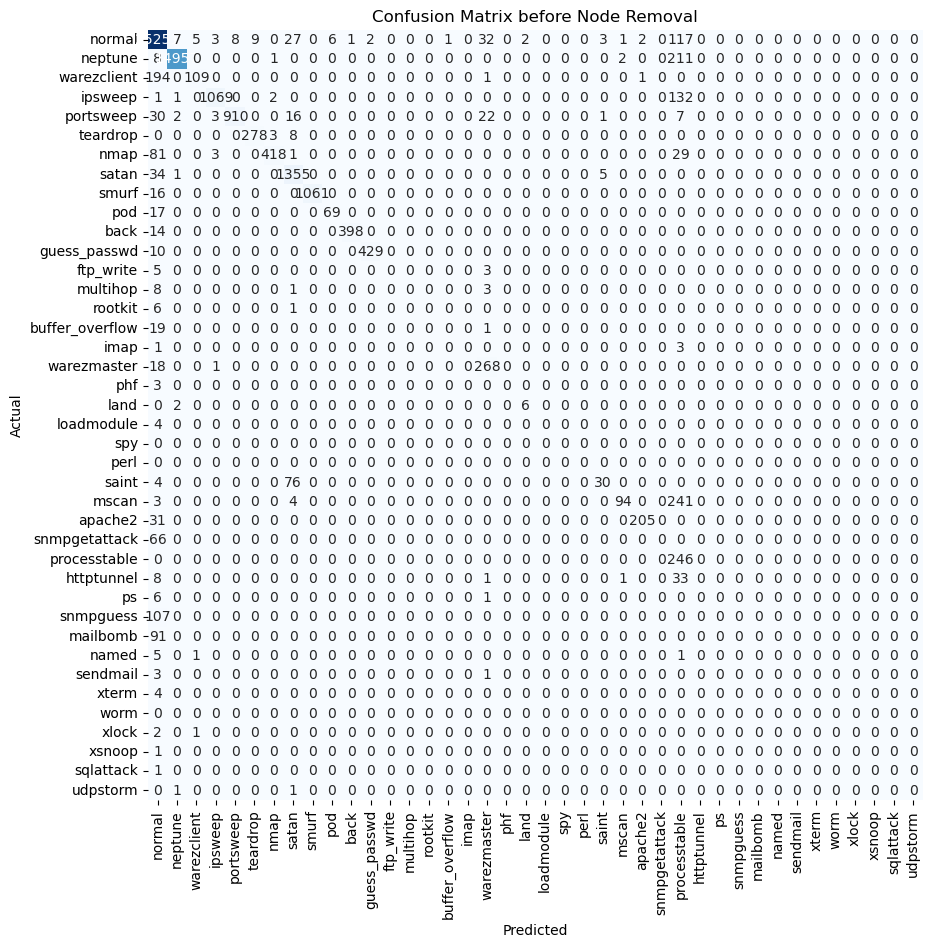

Accuracy after unlearning for class 9 : 0.9621097735156091


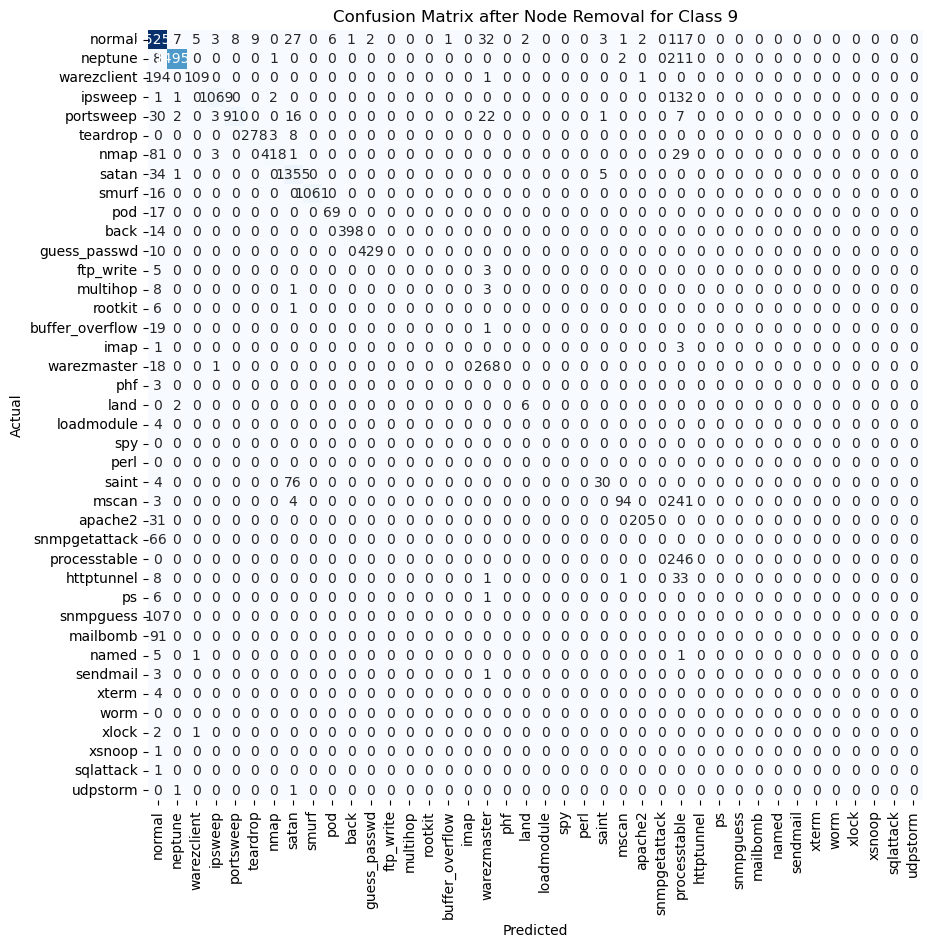

In [24]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def remove_nodes_for_class(tree, class_label_to_unlearn, X_train, y_train):
    """
    Prune nodes associated with a specific class label from a decision tree.

    Parameters:
    - tree: DecisionTreeClassifier object representing the decision tree model.
    - class_label_to_unlearn: Label of the class for which nodes need to be pruned.
    - X_train: Training features.
    - y_train: Training labels.

    Returns:
    - pruned_tree: New DecisionTreeClassifier object with nodes associated with the specified class pruned.
    """

    # Initialize a new decision tree classifier
    pruned_tree = DecisionTreeClassifier(random_state=42)

    # Copy the structure of the original tree
    pruned_tree = tree.__class__()
    pruned_tree.__dict__ = tree.__dict__.copy()

    # Find instances of the specified class label in the training data
    class_indices = np.where(y_train == class_label_to_unlearn)[0]

    # Find the indices of nodes associated with the specified class label
    nodes_to_prune = []
    for idx in class_indices:
        node_index = tree.apply(X_train[idx:idx+1])[0]
        if tree.tree_.value[node_index].argmax() == class_label_to_unlearn:
            nodes_to_prune.append(node_index)

    # Prune the identified nodes
    for node_index in nodes_to_prune:
        pruned_tree.tree_.children_left[node_index] = -1
        pruned_tree.tree_.children_right[node_index] = -1

    return pruned_tree

# Train a decision tree classifier on the training data
tree_classifier = DecisionTreeClassifier(random_state=42, max_depth=8)
tree_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = tree_classifier.predict(X_test)

# Calculate accuracy before unlearning
accuracy_before_unlearning = accuracy_score(y_test, y_pred)
print("Accuracy before unlearning:", accuracy_before_unlearning)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels_list)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix before Node Removal')
plt.show()


# Specify the class label for unlearning (e.g., class 9 for digit 9 in MNIST)
class_label_to_remove = 9

# Remove nodes associated with the specified class label
pruned_tree = remove_nodes_for_class(tree_classifier, class_label_to_remove, X_train, y_train)

# Make predictions on the testing set using the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)

# Calculate accuracy after unlearning
accuracy_after_unlearning = accuracy_score(y_test, y_pred_pruned)
print("Accuracy after unlearning for class", class_label_to_remove, ":", accuracy_after_unlearning)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_pruned, labels=labels_list)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after Node Removal for Class {}'.format(class_label_to_remove))
plt.show()


This is not forgetting as the accuracy drop is minimal and it is across all the classes, not only in `forget class` (this case it is 9).

# Extracting the decision rules with different mechanism: `chain` of `if` statements

In [26]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= f'{class_names[l]}' #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(41)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = dt_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(dt_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open('mnist_decision_tree_inference.py', 'w') as f:
    f.write(cap.stdout)

In [27]:
from mnist_decision_tree_inference import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
    
y_train_pred_tree = []
for i,test_samples in enumerate(X_train):
    y_train_pred_tree.append(decision_tree_inference(test_samples))
    
for i in range(len(y_train_pred_tree)):
    if y_train_pred_tree[i] is None:
        y_train_pred_tree[i] = 0

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_test_pred_tree), accuracy_score(y_train, y_train_pred_tree))

0.962375025504999 0.9658409125169589


#### Verifying that the number of 'if' statements is equal to the number of leaves.

In [28]:
with open('mnist_decision_tree_inference.py', 'r') as f:
    rules = f.readlines()

counter_if = 0
for rule in rules:
    if 'if' in rule:
        counter_if = counter_if+1
print(counter_if)

126


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


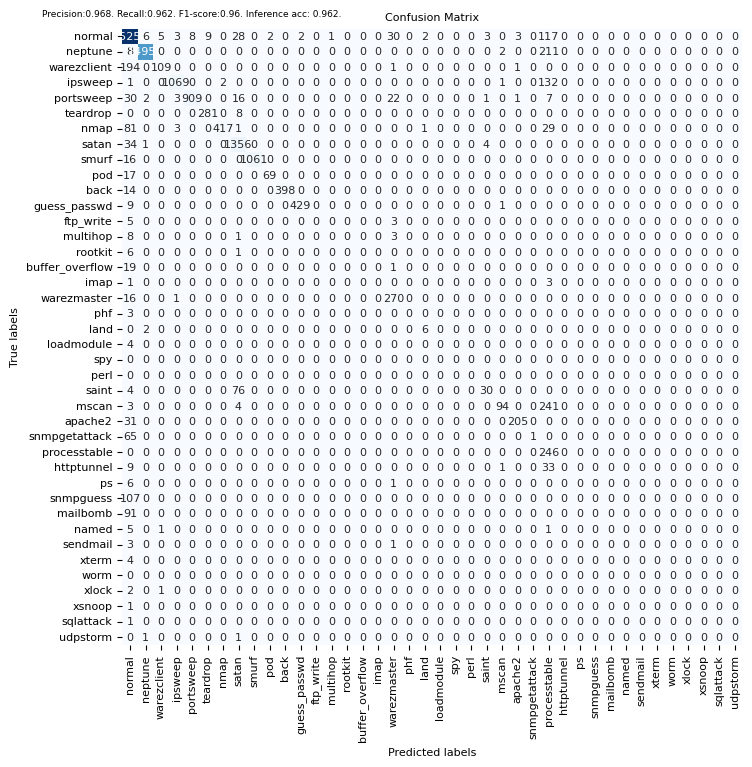

C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9675420755710125
Recall: 0.962375025504999
F1 Score: 0.9603521400244327
True Positives for Each Class: [25258 14958   109  1069   909   281   417  1356  1061    69   398   429
     0     0     0     0     0   270     0     6     0     0     0    30
    94   205     1   246     0     0     0     0     0     0     0     0
     0     0     0     0]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

        apache2       0.98      0.87      0.92       236
           back       1.00      0.97      0.98       412
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         8
   guess_passwd       1.00      0.98      0.99       439
     httptunnel       0.00      0.00      0.00        43
           imap       0.00      0.00      0.00         4
        ipsweep       0.99      0.89      0.94      1205
           land       0.67      0.75      0.71         8
     loadmodule       0.00      0.00      0.00         4
       mailbomb       0.00      0.00      0.00        91
          mscan       0.95      0.27      0.43       342
       multihop       0.00      0.00      0.00        12
          named       0.00      0.00      0.00         7
        neptune       1.00      0.99      0.99     15179
           nmap       1.00      0.78      0.88       532
         normal       0.97    

C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tree, labels = labels_list)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_list, 
            yticklabels=labels_list, annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig('confusion_matrix_mnist.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

##### Forgetting class 9.   

Unlearning time: 0.0042078495025634766 seconds
0.962375025504999
Inference time per sample after unlearn: 2.350327531261557e-05 seconds


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


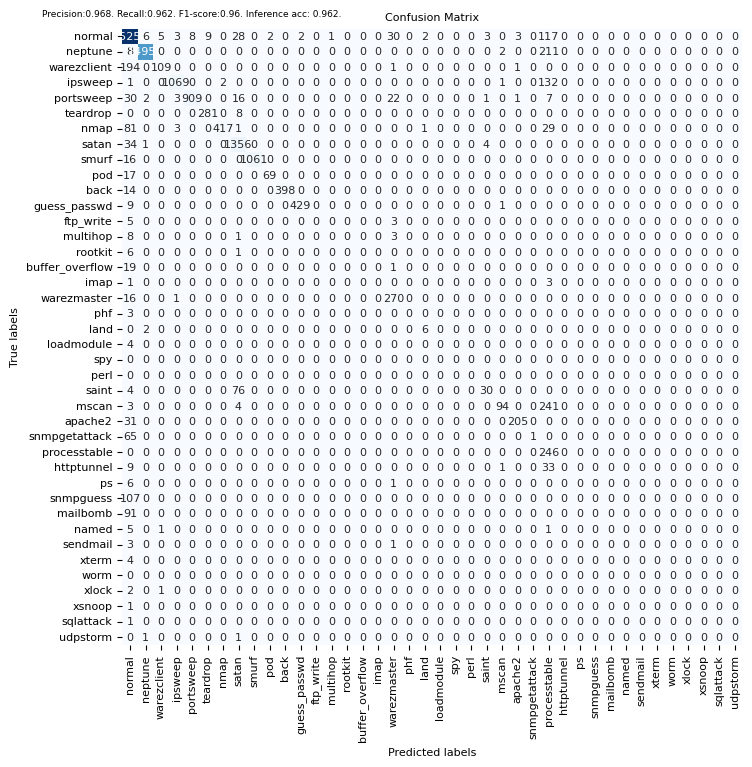

C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9675420755710125
Recall: 0.962375025504999
F1 Score: 0.9603521400244327
True Positives for Each Class: [25258 14958   109  1069   909   281   417  1356  1061    69   398   429
     0     0     0     0     0   270     0     6     0     0     0    30
    94   205     1   246     0     0     0     0     0     0     0     0
     0     0     0     0]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

        apache2       0.98      0.87      0.92       236
           back       1.00      0.97      0.98       412
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         8
   guess_passwd       1.00      0.98      0.99       439
     httptunnel       0.00      0.00      0.00        43
           imap       0.00      0.00      0.00         4
        ipsweep       0.99      0.89      0.94      1205
           land       0.67      0.75      0.71         8
     loadmodule       0.00      0.00      0.00         4
       mailbomb       0.00      0.00      0.00        91
          mscan       0.95      0.27      0.43       342
       multihop       0.00      0.00      0.00        12
          named       0.00      0.00      0.00         7
        neptune       1.00      0.99      0.99     15179
           nmap       1.00      0.78      0.88       532
         normal       0.97    

C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
import time
start_time = time.time()

forget_class = 'normal'
with open('mnist_decision_tree_inference.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

node_removal=[]
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        
        

with open('forget_9_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()
from forget_9_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree, labels = labels_list)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_list, 
            yticklabels=labels_list, annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearning method: learning all labels except `normal`.

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 0.30426692962646484 seconds
Accuracy: 0.9940135907669075
